# Barcode Detection and Processing

This notebook contains functions for detecting, cropping, and enhancing barcodes in images using OpenCV.

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Barcode Detection and Cropping

The following function detects a barcode in an image, crops it, and ensures it's properly aligned.

In [44]:
def detect_and_crop_barcode(image):
    """
    Detects, crops, and centralizes a barcode in an image.
    Returns the cropped and aligned barcode image.
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply gradient detection
    gradient_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    gradient = cv2.subtract(gradient_x, gradient_y)
    gradient = cv2.convertScaleAbs(gradient)

    # Blur and threshold the gradient image
    blurred_gradient = cv2.blur(gradient, (9, 9))
    _, thresh = cv2.threshold(blurred_gradient, 225, 255, cv2.THRESH_BINARY)

    # Apply morphological operations to connect components
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Perform multiple dilations to merge nearby components
    closed = cv2.erode(closed, None, iterations=4)
    closed = cv2.dilate(closed, None, iterations=4)

    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        raise ValueError("No barcode contours found")

    # Find the largest contour
    c = max(contours, key=cv2.contourArea)

    # Get the minimum area rectangle
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int32(box)

    # Get width and height of the detected rectangle
    width = int(rect[1][0])
    height = int(rect[1][1])

    # Ensure width is larger than height
    if width < height:
        width, height = height, width

    # Order points for perspective transform
    src_pts = order_points(box)

    # Define destination points for a straight barcode
    dst_pts = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype=np.float32)

    # Calculate perspective transform matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    # Apply perspective transformation
    warped = cv2.warpPerspective(gray, M, (width, height))

    # Ensure barcode is horizontal (wider than tall)
    if warped.shape[0] > warped.shape[1]:
        warped = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)

    return warped

## Helper Function for Point Ordering

This function helps order points for proper perspective transformation.

In [45]:
def order_points(pts):
    """
    Orders points in top-left, top-right, bottom-right, bottom-left order.
    Important for correct perspective transform.
    """
    # Initialize ordered coordinates
    rect = np.zeros((4, 2), dtype=np.float32)

    # Top-left point has smallest sum
    # Bottom-right point has largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # Top-right point has smallest difference
    # Bottom-left point has largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

## Barcode Enhancement

This function enhances the cropped barcode image for better recognition.

In [46]:
def enhance_barcode(image):
    """
    Enhances the cropped barcode image for better recognition.
    """
    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        image,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        31,  # block size
        10   # C constant
    )

    # Apply morphological operations to clean up the image
    kernel = np.ones((1, 3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    return thresh

## Complete Processing Pipeline

This function combines all steps to process a barcode image.

In [47]:
def process_barcode_image(image_path):
    """
    Complete pipeline for processing a barcode image.
    """
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Could not read image")

    # Detect and crop barcode
    cropped = detect_and_crop_barcode(image)

    # Enhance cropped barcode
    enhanced = enhance_barcode(cropped)

    return enhanced

## Example Usage

Here's how to use the pipeline with an example image:

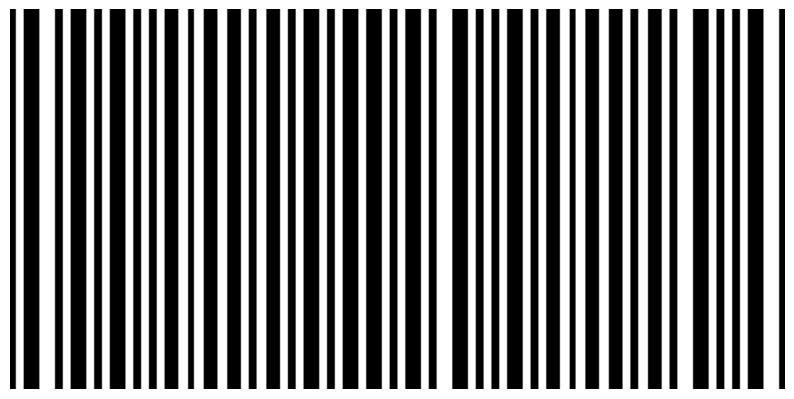

In [48]:
# Process an example image
image_path = "../Barcode-Reader-CV-Proj/Test Cases-20241123/02 - still easy.jpg"
result = process_barcode_image(image_path)
img_rgb =cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,8))
plt.imshow(img_rgb)
plt.axis('off')  # Hide axes
plt.show()